# Predicting Relationship between manufacturing cost and number of units

## Problem:

> Let's assume I work as a consultant to a start-up company that was looking 
to develop a model to estimate the cost of goods sold as they vary the production volume 
(number of units produced). The startup gathered data and has asked me to develop a model to 
predict its cost vs. the number of units sold.

Kaggle Dataset >>> https://www.kaggle.com/vinicius150987/manufacturing-cost

In [2]:
import numpy as np
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/manufacturing-cost/EconomiesOfScale.csv


## Analyze Data

In [3]:
df = pd.read_csv('/kaggle/input/manufacturing-cost/EconomiesOfScale.csv')
df.head()

,Number of Units,Manufacturing Cost
0,1.000000,95.066056
1,1.185994,96.531750
2,1.191499,73.661311
3,1.204771,95.566843
4,1.298773,98.777013


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Number of Units     1000 non-null   float64
 1   Manufacturing Cost  1000 non-null   float64
dtypes: float64(2)
memory usage: 15.8 KB


In [5]:
df.describe()

,Number of Units,Manufacturing Cost
count,1000.000000,1000.000000
mean,4.472799,40.052999
std,1.336241,10.595322
min,1.000000,20.000000
25%,3.594214,32.912036
50%,4.435958,38.345781
75%,5.324780,44.531822
max,10.000000,100.000000


## Data Visualizations

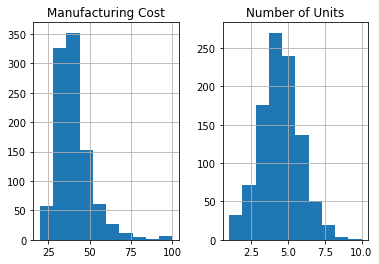

In [7]:
df.hist();

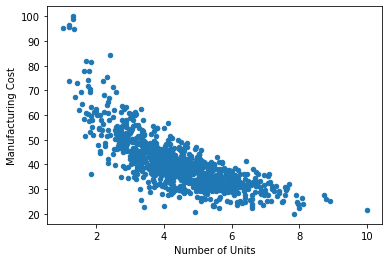

In [10]:
df.plot(kind='scatter', x='Number of Units', y='Manufacturing Cost');

## Train/Split

In [34]:
from sklearn.model_selection import train_test_split

# Train/Split Data

np.random.seed(42)

X = np.array(df['Number of Units'])
X = X.reshape(-1, 1)
y = df['Manufacturing Cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 1), (200, 1), (800,), (200,))

# Modeling

We try three models and then use the best one and performing feature engineering and hyptertuning to get the accuracy of 
the model to as close to 100% as possible

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


model_dict = {
    'RandomForestRegressor': RandomForestRegressor(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}


def model_scores(models, X_train, X_test, y_train, y_test):
    
    np.random.seed(42)
    
    results = {}
    
    for name, model in models.items():
        
        model.fit(X_train, y_train)
        results[name] = model.score(X_test, y_test)
        
    return results

In [37]:
model_scores(model_dict, X_train, X_test, y_train, y_test)

{'RandomForestRegressor': 0.3021005374224023,
 'Lasso': 0.585449898879745,
 'ElasticNet': 0.5802675128295119}

## Improve Models using Featuring Engineering

All the model produced terrible accuracy, let's see how we can improve. Let's try adding a column to see what that does

## Add a column to dataset called 'UnitsBucket'

In [54]:
df["UnitsBucket"] = df["Number of Units"] // .05 * .05
df[["UnitsBucket", "Manufacturing Cost"]].groupby(["UnitsBucket"]).mean()

,Manufacturing Cost
UnitsBucket,
0.95,95.066056
1.15,85.096530
1.20,95.566843
1.25,98.777013
1.30,97.379878
...,...
8.05,25.212477
8.70,27.536542
8.75,25.973787


In [59]:
np.random.seed(42)

X = df.drop('Manufacturing Cost', axis=1)
y = df['Manufacturing Cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_scores(model_dict, X_train, X_test, y_train, y_test)

{'RandomForestRegressor': 0.3027983492807469,
 'Lasso': 0.5853042287304533,
 'ElasticNet': 0.5879928910194102}

Looks like the Elastic Net did improve to .587 beating the Lasso Model

Let's try shuffling the dataset to see if that improves ay of the models

## Shuffle Data?

In [56]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


train_set_shuffled, test_set_shuffled = split_train_test(df, 0.2)

In [58]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

df_with_id = df.reset_index()  # adds an 'index' column
train_set_shuffled, test_set_shuffled = split_train_test_by_id(df_with_id, 0.2, "index")


np.random.seed(42)

X_train_shuffled = train_set_shuffled.drop('Manufacturing Cost', axis=1)
y_train_shuffled = train_set_shuffled['Manufacturing Cost']
X_test_shuffled = test_set_shuffled.drop('Manufacturing Cost', axis=1)
y_test_shuffled = test_set_shuffled['Manufacturing Cost']


model_scores(model_dict, X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled)

{'RandomForestRegressor': 0.568464108782889,
 'Lasso': 0.48307909781517544,
 'ElasticNet': 0.4915076096116557}

Let's try adding one more column to see if that improves scores

## Add a column called 'Cost/Unit'

In [63]:
df['Cost/Unit'] = df['Manufacturing Cost'] / df['Number of Units']

df.head()

,Number of Units,Manufacturing Cost,UnitsBucket,Cost/Unit
0,1.000000,95.066056,0.95,95.066056
1,1.185994,96.531750,1.15,81.393142
2,1.191499,73.661311,1.15,61.822404
3,1.204771,95.566843,1.20,79.323632
4,1.298773,98.777013,1.25,76.054111


In [67]:
np.random.seed(42)

X = df.drop('Manufacturing Cost', axis=1)
y = df['Manufacturing Cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_scores(model_dict, X_train, X_test, y_train, y_test)


{'RandomForestRegressor': 0.9802953314416548,
 'Lasso': 0.7750097193716372,
 'ElasticNet': 0.7787543830671989}

Wow, by adding a 'cost/unit' column it improved the RandomForestRegressor model to 98% accuracy! Not
bad at all. Now let's try hypertuning this model with RandomizedSearchCV to see if we can improve 
the RandomForestRegressor model even more

## Hypertuning RandomForestRegressor with RandomizedSearchCV

In [69]:
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           }

randSearchCV_model = RandomizedSearchCV(RandomForestRegressor(),
                                       param_distributions=rf_grid,
                                       cv=5,
                                       verbose=True,
                                       n_iter=20)

randSearchCV_model.fit(X_train, y_train)
randSearchCV_model.score(X_test, y_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.1s finished


0.9151706900722224

So hypertuning actually reduced the accuracy of our model

In [70]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.980332107384815

The simple RandomForestRegressor model is the best model for predicting manufacturing cost for the units to be produced

Now let's evaluate the model

## Model Evaluation

In [74]:
# Create evaluation function 
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Test MAE": mean_absolute_error(y_test, test_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Test RMSLE": rmsle(y_test, test_preds),
              "Training R^2": model.score(X_train, y_train),
              "Test R^2": model.score(X_test, y_test)}
    return scores

show_scores(rf_model)

{'Training MAE': 0.279291976466315,
 'Test MAE': 0.6702974874599346,
 'Training RMSLE': 0.0106162604075862,
 'Test RMSLE': 0.03308515563962304,
 'Training R^2': 0.9973416479299901,
 'Test R^2': 0.980332107384815}

We have a very small mean absolute error which is greate and a high r-squared which shows how accurate the model is

## Compare Predictions and Actuals

In [94]:
np.random.seed(42)

y_preds = rf_model.predict(X_test)

df_comparison = pd.DataFrame()

df_comparison['Num of Units'] = X_test['Number of Units']
df_comparison['Predicted Manufacturing Cost'] = y_preds
df_comparison['Actual Manufacturing Cost'] = y_test
df_comparison['Error'] = df_comparison['Predicted Manufacturing Cost'] - df_comparison['Actual Manufacturing Cost']
df_sorted = df_comparison.sort_values(by=['Num of Units'], ascending=True)
df_sorted.head(20)

,Num of Units,Predicted Manufacturing Cost,Actual Manufacturing Cost,Error
10,1.540898,72.525611,69.284097,3.241515
23,1.815917,68.730187,69.178731,-0.448545
25,1.831097,46.384710,36.085800,10.298910
30,1.874144,58.099843,58.060460,0.039384
39,2.105273,59.236520,60.218901,-0.982381
44,2.171317,55.525377,54.109948,1.415429
54,2.332039,63.485186,65.268370,-1.783184
55,2.339399,56.565579,54.029852,2.535728
59,2.363756,66.585007,66.712684,-0.127677
60,2.379992,57.247823,57.828320,-0.580497


## Comparison Graph

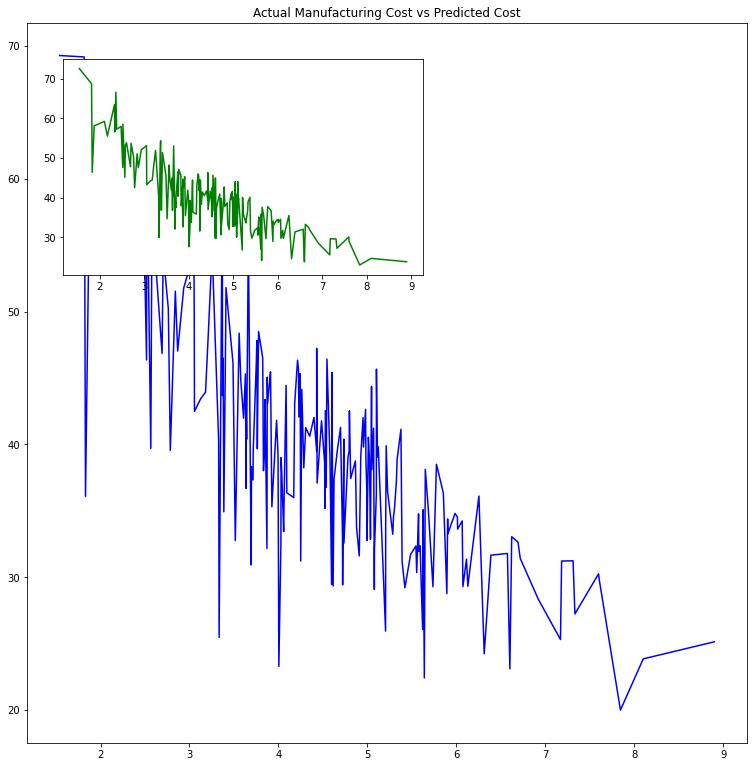

In [96]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0.05, 0.65, 0.5, 0.3])

ax1.set_title('Actual Manufacturing Cost vs Predicted Cost')

ax1.plot(df_sorted['Num of Units'],
        df_sorted['Actual Manufacturing Cost'],
        color='blue')


ax2.set_title('Predicted Cost')
ax2.plot(df_sorted['Num of Units'],
        df_sorted['Predicted Manufacturing Cost'],
        color='green')

plt.show();
